# Fitbit Competition
Analyzying a friendly fitbit steps competition between friends. Compeition includes a workweek competition each week which consists of Monday through Friday, and a weekend competition which is Saturday and Sunday.


## Table of Contents
1. [Access Data](#Access_Data)
2. [Analyze Data](#Analyze_Data) - View the final graph output

## Set Up Variables

In [25]:
* Set the path to the folder *;
%let rc = %sysfunc(filename(fr,.));
%let curdir = %sysfunc(pathname(&fr));
%let rc = %sysfunc(filename(fr));
%let path = &curdir;

%let data=&path\data;
%let outpath=&path\images;


* Import following SAS column naming conventions *;
options validvarname=v7;


* Create a print marco to print the first five rows of a table by default *;
%macro head(tbl,n=5);
    proc print data=&tbl(obs=&n) noobs;
    run;
%mend head;



*************************************;
* Set up graph formatting variables *;
*************************************;

* Color to use for text *;
%let textColor=cx768396;

* Axis label and value size *;
%let AxisLabel=14pt;
%let AxisValue=12pt;
%let TitleSize=16pt;

* Set the title options to the title color and alwyas left justify *;
%let fmtTitle=height=&TitleSize color=&textColor justify=left;

* Add current date to footnote *;
%let footnoteDate=%sysfunc(today(),mmddyy10.);

* Set the footnote options to the title color and alwyas left justify *;
%let fmtFootnote=height=8pt color=&textColor justify=left;

* Set the x and y axis formatting *;
%let fmtAxes=labelattrs=(size=&AxisLabel color=&textColor)
             valueattrs=(size=&AxisValue color=&textColor);
    
%let fmtXaxis=&fmtAxes;
           
%let fmtYaxis=&fmtAxes;


57                                                         The SAS System                             14:29 Thursday, April 28, 2022

755        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
755      ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
756        
757        * Set the path to the folder *;
758        %let rc = %sysfunc(filename(fr,.));
759        %let curdir = %sysfunc(pathname(&fr));
760        %let rc = %sysfunc(filename(fr));
761        %let path = &curdir;
762        
763        %let data=&path\data;
764        %let outpath=&path\images;
765        
766        
767        * Import following SAS column naming conventions *;
768        options validvarname=v7;
769        
770        
771        * Create a print marco to print the first five rows of a table by default *;
772        %macro head(tbl,n=5);
773            proc print data=&tbl(obs=&n) noobs;
774 

## <a id='Access_Data'>Access Data</a>
Import the csv file as a SAS data set.

In [26]:
proc import datafile="&data/fitbit.csv"
            out=fitbit_raw
            dbms=csv 
            replace;
run;


%head(fitbit_raw)

Start_Date,Type,Ryan,Kevin,Peter
01/18/2021,Workweek hustle,25907,45099,38439
01/23/2021,Weekend,15502,23640,22362
01/25/2021,Workweek hustle,31255,38688,25393
01/30/2021,Weekend,22645,22356,20588
02/01/2021,Workweek hustle,39787,43670,40824


## Explore Data

Confirm the column names and data types were imported correctly.

In [27]:
* Select only the column info output of PROC CONTENTS *;
ods trace on;
ods select variables;


* View the descriptor portion of the data *;
proc contents data=fitbit_raw;
run;

Confirm only two unique values in the Type column: **Weekend** and **Workweek** hustle

In [28]:
proc freq data=fitbit_raw;
    tables Type;
run;

Type,Frequency,Percent,CumulativeFrequency,CumulativePercent
Weekend,22,48.89,22,48.89
Workweek hustle,23,51.11,45,100.00


Confirm no issues with the data entry using the min and max of the steps recorded.

In [29]:
proc means data=fitbit_raw min max maxdec=0;
    class Type;
run;

Type,N Obs,Variable,Minimum,Maximum
Weekend,22,Start_Date Ryan Kevin Peter,22303 14622 18722 18032,22450 29415 35734 44463
Workweek hustle,23,Start_Date Ryan Kevin Peter,22298 25907 38688 25393,22452 66605 87086 94304


## Data Prep

1. Transpose the data
2. Determine the weekly placement
3. Determine the winner and winner's steps
4. Sort the data
5. Create final tables
6. Add overall points system to *overall*

Preview the raw data.

In [30]:
%head(fitbit_raw)

Start_Date,Type,Ryan,Kevin,Peter
01/18/2021,Workweek hustle,25907,45099,38439
01/23/2021,Weekend,15502,23640,22362
01/25/2021,Workweek hustle,31255,38688,25393
01/30/2021,Weekend,22645,22356,20588
02/01/2021,Workweek hustle,39787,43670,40824


#### 1. Transpose the data, create columns
Take the wide table and make it narrow. 
- Transpose the Ryan, Peter and Kevin columns into one column named 'Person'. 
- Tranpose the steps to match the distinct person in the newly created column.
- Create the **Week** column for each competition. One week can contain a workweek and weekend competition.


In [31]:
data fitbit_narrow;
    set fitbit_raw;
    
* New column for the transposed data. Length needs to be the max length of a name *;
    length Person $5;
    retain Week 0;
    
* Create an array to reference each person's name *;
    array col{3}   $  Ryan Peter Kevin ;
    
* Create an array to create the distinct values in the new column when transposing *;
    array name{3} $ name1-name3 ("Ryan" "Peter" "Kevin");
    if Type="Workweek hustle" then Week+1;
       else Day+2;
        
* Loop over one row three times. Output the steps for person-n in the Steps column, and name for person-n in the Person column. *;
* This will run three times for one row and restructure the data *;
    do i=1 to dim(col);
        Person=name[i];
        Steps=col[i];
        output;
    end;
    
* Drop unncessary columns *;
    drop name: i Ryan Peter Kevin;
run;



* Preview the restructured table *;
%head(fitbit_narrow,n=15)

Start_Date,Type,Person,Week,Day,Steps
01/18/2021,Workweek hustle,Ryan,1,0,25907
01/18/2021,Workweek hustle,Peter,1,0,38439
01/18/2021,Workweek hustle,Kevin,1,0,45099
01/23/2021,Weekend,Ryan,1,2,15502
01/23/2021,Weekend,Peter,1,2,22362
01/23/2021,Weekend,Kevin,1,2,23640
01/25/2021,Workweek hustle,Ryan,2,2,31255
01/25/2021,Workweek hustle,Peter,2,2,25393
01/25/2021,Workweek hustle,Kevin,2,2,38688
01/30/2021,Weekend,Ryan,2,4,22645


#### 2. Determine the weekly placement
Use the RANK procedure to find the placement for each person for each competition.

In [32]:
proc rank data=fitbit_narrow
          out=fitbit_rank
          descending;
    by Start_Date;
    var Steps;
    ranks Place;

%head(fitbit_rank,n=10)

Start_Date,Type,Person,Week,Day,Steps,Place
01/18/2021,Workweek hustle,Ryan,1,0,25907,3
01/18/2021,Workweek hustle,Peter,1,0,38439,2
01/18/2021,Workweek hustle,Kevin,1,0,45099,1
01/23/2021,Weekend,Ryan,1,2,15502,3
01/23/2021,Weekend,Peter,1,2,22362,2
01/23/2021,Weekend,Kevin,1,2,23640,1
01/25/2021,Workweek hustle,Ryan,2,2,31255,2
01/25/2021,Workweek hustle,Peter,2,2,25393,3
01/25/2021,Workweek hustle,Kevin,2,2,38688,1
01/30/2021,Weekend,Ryan,2,4,22645,1


#### 3. Determine the winner and winner's steps
Create a column name **Winner** that indicates the winner for the competition, otherwise **Losers**. 

Then create a new column named **WinnerSteps** that indicates the winners total steps.

In [33]:
* Create a column that indicates the winner's name, all others are losers *;
data fitbit_rank;
    set fitbit_rank;
    if Place=1 then Winner=Person;
        else Winner="Losers";
    if Winner ne "Loser" then WinnerSteps=Steps;
        else WinnerSteps=.;
run;

%head(fitbit_rank,n=10)

Start_Date,Type,Person,Week,Day,Steps,Place,Winner,WinnerSteps
01/18/2021,Workweek hustle,Ryan,1,0,25907,3,Loser,.
01/18/2021,Workweek hustle,Peter,1,0,38439,2,Loser,.
01/18/2021,Workweek hustle,Kevin,1,0,45099,1,Kevin,45099
01/23/2021,Weekend,Ryan,1,2,15502,3,Loser,.
01/23/2021,Weekend,Peter,1,2,22362,2,Loser,.
01/23/2021,Weekend,Kevin,1,2,23640,1,Kevin,23640
01/25/2021,Workweek hustle,Ryan,2,2,31255,2,Loser,.
01/25/2021,Workweek hustle,Peter,2,2,25393,3,Loser,.
01/25/2021,Workweek hustle,Kevin,2,2,38688,1,Kevin,38688
01/30/2021,Weekend,Ryan,2,4,22645,1,Ryan,22645


#### 4. Sort the data
Sort the data by Person and Start Date. This is necessary to for the BY group processing in the DATA step.

In [34]:
proc sort data=fitbit_rank
          out=fitbit_sort;
    by Person Start_date;
run;



%head(fitbit_sort,n=15)

Start_Date,Type,Person,Week,Day,Steps,Place,Winner,WinnerSteps
01/18/2021,Workweek hustle,Kevin,1,0,45099,1,Kevin,45099
01/23/2021,Weekend,Kevin,1,2,23640,1,Kevin,23640
01/25/2021,Workweek hustle,Kevin,2,2,38688,1,Kevin,38688
01/30/2021,Weekend,Kevin,2,4,22356,2,Loser,.
02/01/2021,Workweek hustle,Kevin,3,4,43670,1,Kevin,43670
02/06/2021,Weekend,Kevin,3,6,24110,3,Loser,.
02/08/2021,Workweek hustle,Kevin,4,6,41823,3,Loser,.
02/13/2021,Weekend,Kevin,4,8,18722,2,Loser,.
02/15/2021,Workweek hustle,Kevin,5,8,49281,1,Kevin,49281
02/20/2021,Weekend,Kevin,5,10,23909,3,Loser,.


#### 5. Create final tables
- **fitbit_detail** contains detailed data for each competition
- **overall contains** contains overall standings

In [35]:
data fitbit_detail(drop=win_streak First Second Third) 
     overall(drop=Start_Date Type Steps Place Day Week);
    set fitbit_sort;
    
* Create varialbes to retain through the data step. This will allow them to cumulate *;
    retain win_streak 0 First 0 Second 0 Third 0 total_steps 0 Streak 0;
    
* Create the by group first.Person and last.Person. Use this to cumulate steps, placement and win streak *;
    by Person;
    
* Clear total steps, win streak, first second and third columns when a new person starts *;
    if first.Person then do; 
        total_steps=0;
        win_streak=0;
        Streak=0;
        First=0;
        Second=0;
        Third=0;
    end;
    
* Increase the win streak column for consecutive first places finishes. Clear otherwise *;
    if Place=1 then win_streak+1;
       else win_streak=0;
       
* Store the max win streak in the Streak column *;
    if win_streak>Streak then Streak=win_streak;
    
* Summarize the First, Second and Third place finishes *;
    if Place=1 then First+1;
        else if Place=2 then Second+1;
        else if Place=3 then Third+1;
    
* Increase the cumulative total steps for each person *;
    total_steps+steps;

* Output the rows to the detail table *;
    output fitbit_detail;

* If it's the last row output to the overall table *;
    if last.Person then output overall;
    
* format, label and drop columns *;
    format steps total_steps comma14.;
    label
        total_steps="Total Steps"
        Streak="Win Streak"
        Place="Competition Place"
        Start_date="Start Date"
        First="1st"
        Second="2nd"
        Third="3rd";
    drop win_streak;
run;


* Preview both tables *;
title "Rows in the fitbit_detail table";
%head(fitbit_detail,n=20)

title "Rows in overall table";
%head(overall)

title;

Start_Date,Type,Person,Week,Day,Steps,Place,Winner,WinnerSteps,total_steps,Streak
01/18/2021,Workweek hustle,Kevin,1,0,"45,099",1,Kevin,45099,"45,099",1
01/23/2021,Weekend,Kevin,1,2,"23,640",1,Kevin,23640,"68,739",2
01/25/2021,Workweek hustle,Kevin,2,2,"38,688",1,Kevin,38688,"107,427",3
01/30/2021,Weekend,Kevin,2,4,"22,356",2,Loser,.,"129,783",3
02/01/2021,Workweek hustle,Kevin,3,4,"43,670",1,Kevin,43670,"173,453",3
02/06/2021,Weekend,Kevin,3,6,"24,110",3,Loser,.,"197,563",3
02/08/2021,Workweek hustle,Kevin,4,6,"41,823",3,Loser,.,"239,386",3
02/13/2021,Weekend,Kevin,4,8,"18,722",2,Loser,.,"258,108",3
02/15/2021,Workweek hustle,Kevin,5,8,"49,281",1,Kevin,49281,"307,389",3
02/20/2021,Weekend,Kevin,5,10,"23,909",3,Loser,.,"331,298",3


#### 6. Add overall points system to *overall*
- 1st = 3pts
- 2nd = 1pts
- 3rd = 0pts 

In [36]:
proc print data=fitbit_detail;
    format Start_Date weekw5.;
run;

Obs,Start_Date,Type,Person,Week,Day,Steps,Place,Winner,WinnerSteps,total_steps,Streak
1,21W03,Workweek hustle,Kevin,1,0,"45,099",1.0,Kevin,45099,"45,099",1
2,21W03,Weekend,Kevin,1,2,"23,640",1.0,Kevin,23640,"68,739",2
3,21W04,Workweek hustle,Kevin,2,2,"38,688",1.0,Kevin,38688,"107,427",3
4,21W04,Weekend,Kevin,2,4,"22,356",2.0,Loser,.,"129,783",3
5,21W05,Workweek hustle,Kevin,3,4,"43,670",1.0,Kevin,43670,"173,453",3
6,21W05,Weekend,Kevin,3,6,"24,110",3.0,Loser,.,"197,563",3
7,21W06,Workweek hustle,Kevin,4,6,"41,823",3.0,Loser,.,"239,386",3
8,21W06,Weekend,Kevin,4,8,"18,722",2.0,Loser,.,"258,108",3
9,21W07,Workweek hustle,Kevin,5,8,"49,281",1.0,Kevin,49281,"307,389",3
10,21W07,Weekend,Kevin,5,10,"23,909",3.0,Loser,.,"331,298",3


In [37]:
data overall;
    set overall;
    Points=(First*3)+(Second*1);
run;

* Sort the standings by points descending *;
proc sort data=overall;
    by descending Points;
run;

%head(overall)

Person,Winner,WinnerSteps,First,Second,Third,total_steps,Streak,Points
Kevin,Kevin,63566,21,17,7,"1,822,131",3,80
Peter,Loser,.,18,13,13,"1,823,433",6,67
Ryan,Loser,.,6,14,24,"1,560,439",2,32


## <a id='Analyze_Data'>Analyze Data</a>

Create attribute map so each individual has a specific color mapped to the distinct value.

In [38]:
data attrs;
length linecolor $ 9 fillcolor $ 9;
input ID $ value $ linecolor $ fillcolor $ MarkerColor $;
datalines;
    myid Kevin cx2ecc71 cx2ecc71 cx2ecc71
    myid Peter cx3498db cx3498db cx3498db
    myid Ryan cxf39c12 cxf39c12 cxf39c12
;
run;

title "Individual Colors";
%head(attrs)



data winner;
length linecolor $ 9 fillcolor $ 9;
input ID $ value $ linecolor $ fillcolor $ MarkerColor $;
datalines;
    myid Kevin cx2ecc71 cx2ecc71 cx2ecc71
    myid Peter cx3498db cx3498db cx3498db
    myid Ryan cxf39c12 cxf39c12 cxf39c12
    myid Loser cxd3d3d3 cxd3d3d3 cxd3d3d3
;
run;

title "Winner/Loser Colors";
%head(winner)

linecolor,fillcolor,ID,value,MarkerColor
cx2ecc71,cx2ecc71,myid,Kevin,cx2ecc71
cx3498db,cx3498db,myid,Peter,cx3498db
cxf39c12,cxf39c12,myid,Ryan,cxf39c12
linecolor,fillcolor,ID,value,MarkerColor
cx2ecc71,cx2ecc71,myid,Kevin,cx2ecc71
cx3498db,cx3498db,myid,Peter,cx3498db
cxf39c12,cxf39c12,myid,Ryan,cxf39c12
cxd3d3d3,cxd3d3d3,myid,Loser,cxd3d3d3


### 1. Overall Standings
Overall standings of the fitbit competition.


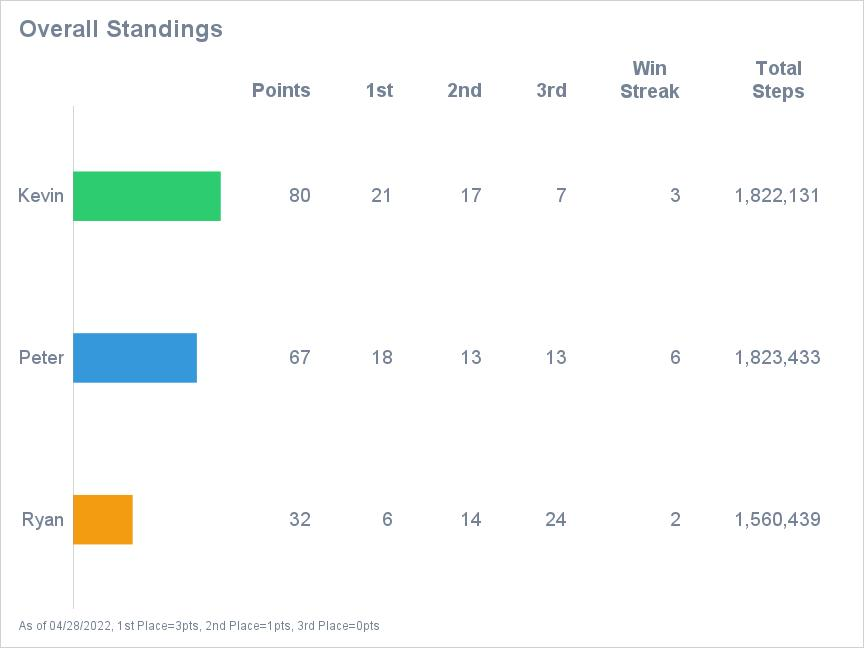

In [39]:
ods listing gpath="&outpath";
ods graphics / width=9in imagename="OverallStandings" imagefmt=jpeg;


title &fmtTitle "Overall Standings";
footnote &fmtFootnote  "As of %sysfunc(today(),mmddyy10.), 1st Place=3pts, 2nd Place=1pts, 3rd Place=0pts";

proc sgplot data=overall
            noborder 
            dattrmap=attrs
            noautolegend;
    hbarparm category=Person response=Points /
          nooutline 
          group=Person
          barwidth=.3
          attrID=myID
           ;
    yaxistable Points First Second Third  Streak Total_Steps /
        y=Person  
        location=inside 
        pad=10
        valueattrs=(size=12pt color=&textColor)
        labelattrs=(color=&textColor weight=bold size=12pt) pad=20;
    yaxis &fmtYaxis display=(nolabel noticks noline);
    xaxis &fmtXaxis display=none;
run;

title;
footnote;

ods graphics / reset;

### 2. Winner by Competition

Default output


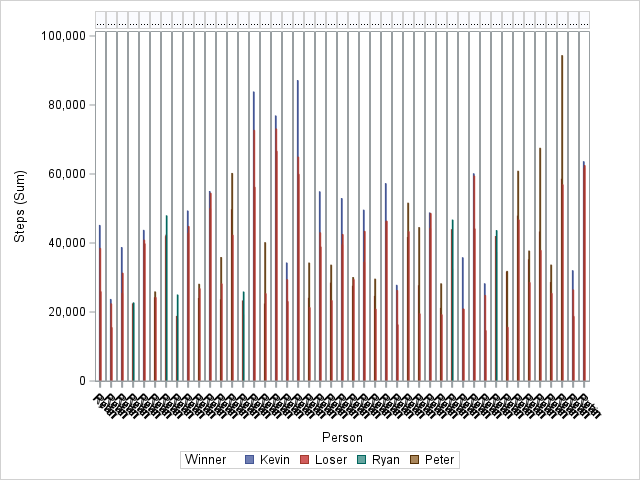

In [40]:
proc sgpanel data=fitbit_detail;
    panelby Start_date /
        layout=columnlattice
        onepanel
    ;
    vbar Person / 
        response=Steps
        group=Winner;
run;              

Update


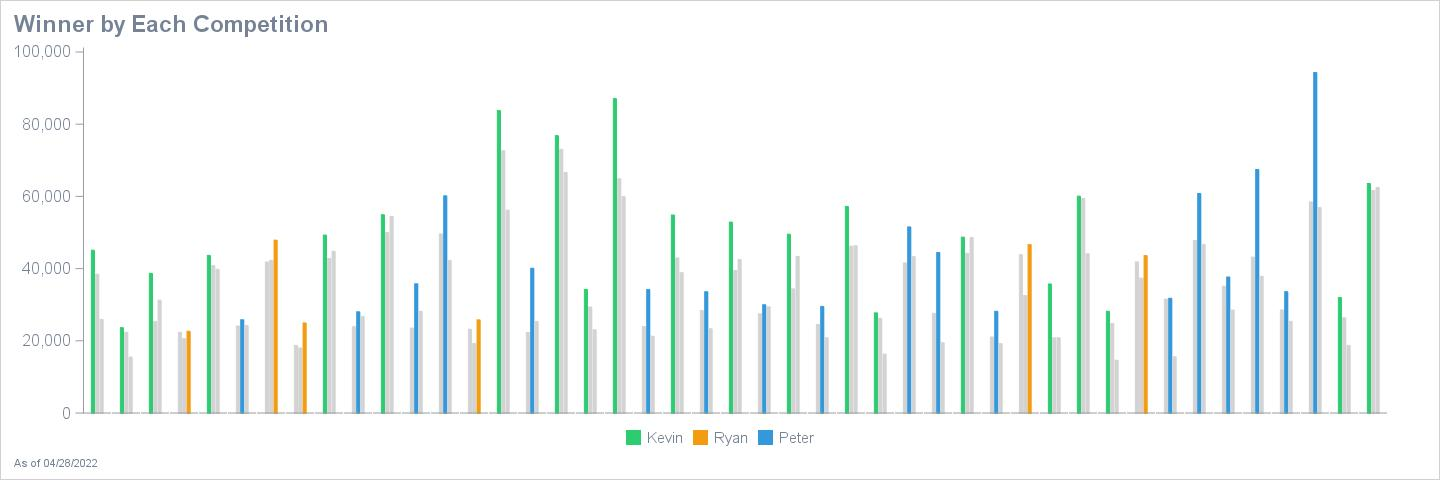

In [41]:
ods listing gpath="&outpath";
ods graphics /  width=15in height=5in imagename="WinnerByCompetition" imagefmt=jpeg;

title &fmtTitle "Winner by Each Competition";
footnote &fmtFootnote  "As of &footnoteDate";

proc sgpanel data=fitbit_detail
             dattrmap=winner;
    panelby Start_Date / 
        layout=columnlattice
        onepanel
        noheader
        noborder
        nowall;
    vbar Person /
        response=Steps
        group=Winner
        barwidth=.6
        attrID=myID;
    rowaxis display=(nolabel) &fmtXaxis;
    colaxis display=none &fmtYaxis;
    keylegend / 
        position=bottom
        exclude=("Loser")
        noborder
        title=""
        valueattrs=(color=&textColor size=11pt)
        scale=1.5;
run;
title;

ods graphics / reset;

### 3. Cumulative Steps by Week
Viewing the cumulative steps by each Person by each competition. 

Default output


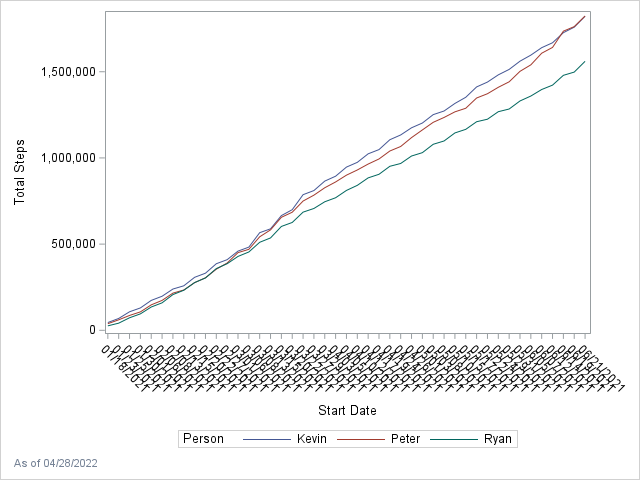

In [42]:
proc sgplot data=fitbit_detail;
    vline Start_Date /
        group=Person
        response=Total_Steps;
run;
    

Update


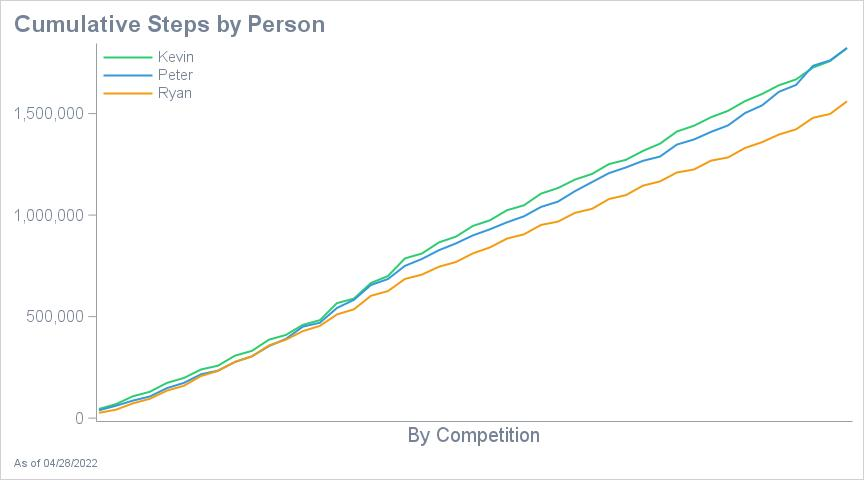

In [43]:
ods listing gpath="&outpath";
ods graphics / width=9in height=5in imagename="CumulativeSteps" imagefmt=jpeg;

title &fmtTitle "Cumulative Steps by Person";

proc sgplot data=fitbit_detail
            noborder
            dattrmap=attrs;
    vline Start_date / 
        response=total_steps
        group=Person

        lineattrs=(thickness=2)
        attrID=myID;
    keylegend / 
        across=1
        position=topleft
        location=inside
        noborder
        title=""
        valueattrs=(color=&textColor size=11pt);
    yaxis &fmtYaxis display=(nolabel);
    xaxis &fmtXaxis label="By Competition" display=(novalues noticks);
run;

title;
footnote;

ods graphics / reset;

### 4. Steps by Competition

In [44]:

%macro stepsByPerson(competition);

%let clean=%upcase(&competition);

title &fmtTitle "%upcase(&clean) Steps by Competition";
footnote &fmtFootnote  "As of &footnoteDate";

proc sgpanel data=fitbit_detail
            dattrmap=attrs 
            noautolegend;
    panelby Person / 
        layout=columnlattice 
        novarname
        nowall
        noborder
        headerattrs=(color=&textColor size=12pt weight=bold)
        headerbackcolor=white
        noheaderborder
        spacing=25
        colheaderpos=bottom
    ;
    vbar Week / 
         response=Steps
         attrID=myID 
         group=Person
         groupdisplay=cluster;
    colaxis &fmtYaxis label="Week" display=none;
    rowaxis &fmtXaxis label="Steps"
            values=(0 to 100000 by 20000);
    where upcase(Type)="&clean";

run;

title;

%mend;


95                                                         The SAS System                             14:29 Thursday, April 28, 2022

1298       ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
1298     ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
1299       
1300       
1301       %macro stepsByPerson(competition);
1302       
1303       %let clean=%upcase(&competition);
1304       
1305       title &fmtTitle "%upcase(&clean) Steps by Competition";
1306       footnote &fmtFootnote  "As of &footnoteDate";
1307       
1308       proc sgpanel data=fitbit_detail
1309                   dattrmap=attrs
1310                   noautolegend;
1311           panelby Person /
1312               layout=columnlattice
1313               novarname
1314               nowall
1315               noborder
1316               headerattrs=(color=&textColor size=12pt weight=bold)
1317           


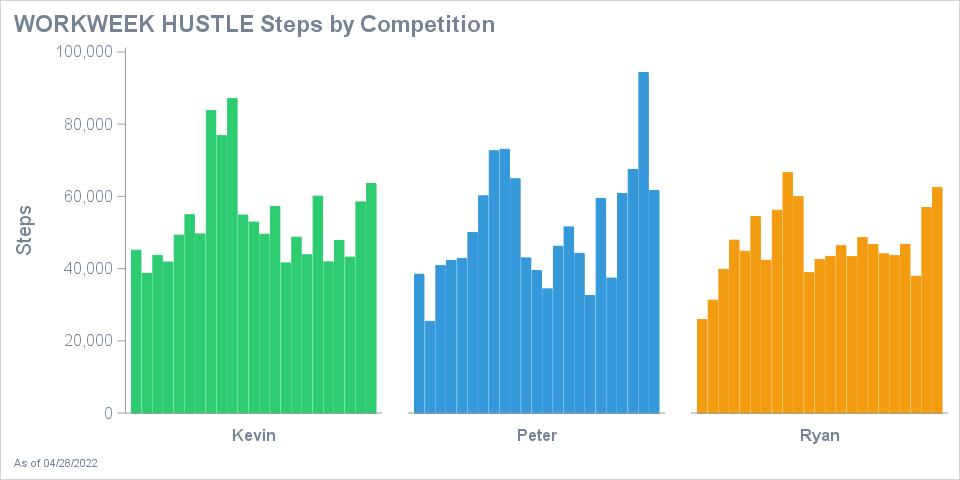
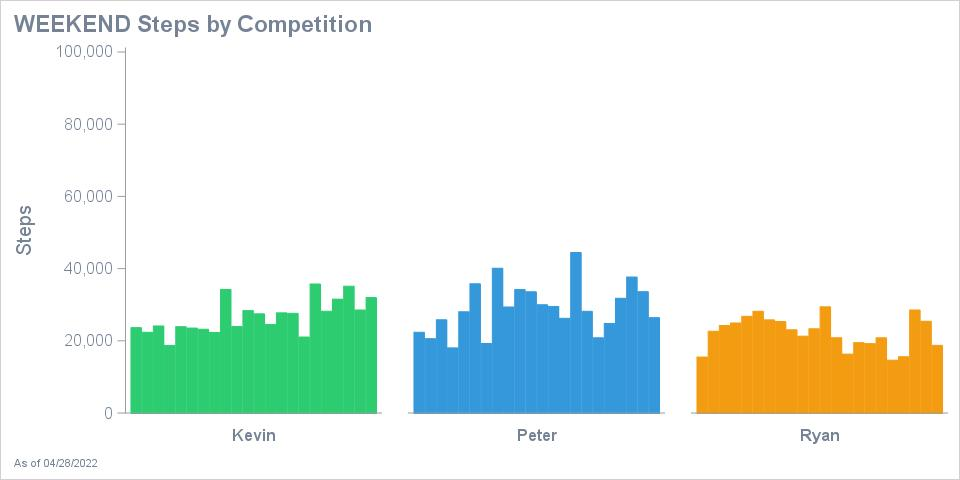

In [45]:
ods listing gpath="&outpath";
ods graphics / width=10in height=5in imagename="WorkweekHustleByPerson" imagefmt=jpeg;
%stepsByPerson(Workweek hustle)

ods listing gpath="&outpath";
ods graphics / width=10in height=5in imagename="WeekendWarriorByPerson" imagefmt=jpeg;
%stepsByPerson(Weekend)


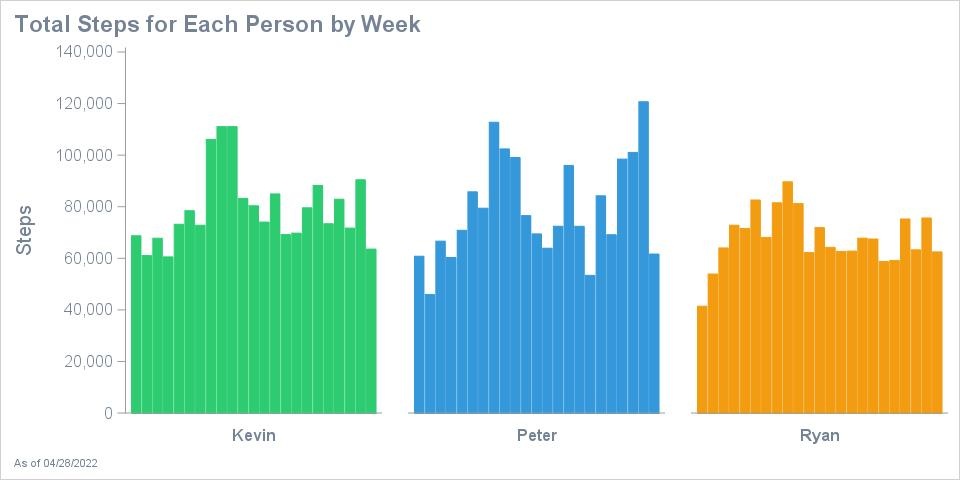

In [46]:
ods listing gpath="&outpath";
ods graphics / width=10in height=5in imagename="StepsByWeek" imagefmt=jpeg;


title &fmtTitle "Total Steps for Each Person by Week";
footnote &fmtFootnote  "As of &footnoteDate";

proc sgpanel data=fitbit_detail
            dattrmap=attrs 
            noautolegend;
    panelby Person / 
        layout=columnlattice 
        novarname
        nowall
        noborder
        headerattrs=(color=&textColor size=12pt weight=bold)
        headerbackcolor=white
        noheaderborder
        spacing=25
        colheaderpos=bottom
    ;
    vbar Week / 
         response=Steps
         attrID=myID 
         group=Person
         groupdisplay=cluster;
    colaxis &fmtYaxis label="Week" display=none;
    rowaxis &fmtXaxis label="Steps"
            values=(0 to 140000 by 20000);
run;


### 5. Boxplot by Each...

Default output


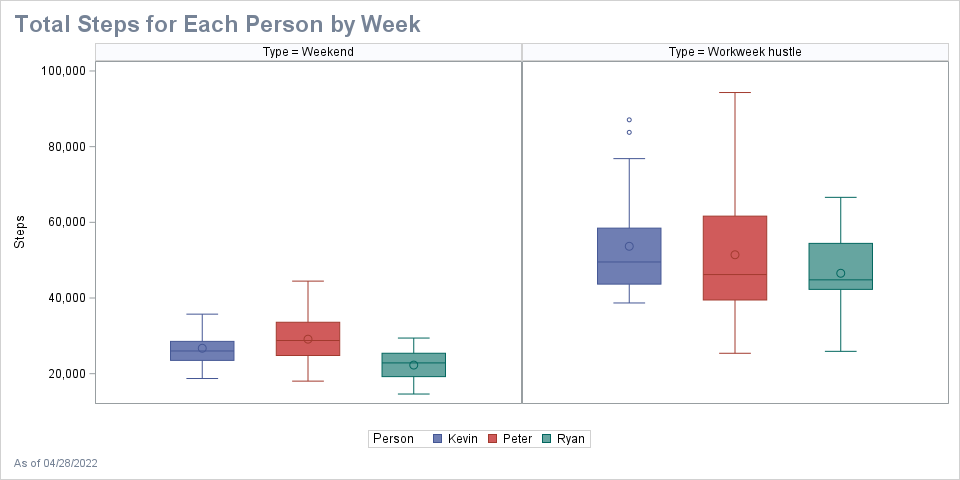

In [47]:
proc sgpanel data=fitbit_detail;
    panelby Type;
    vbox Steps / 
        group=Person;
run;


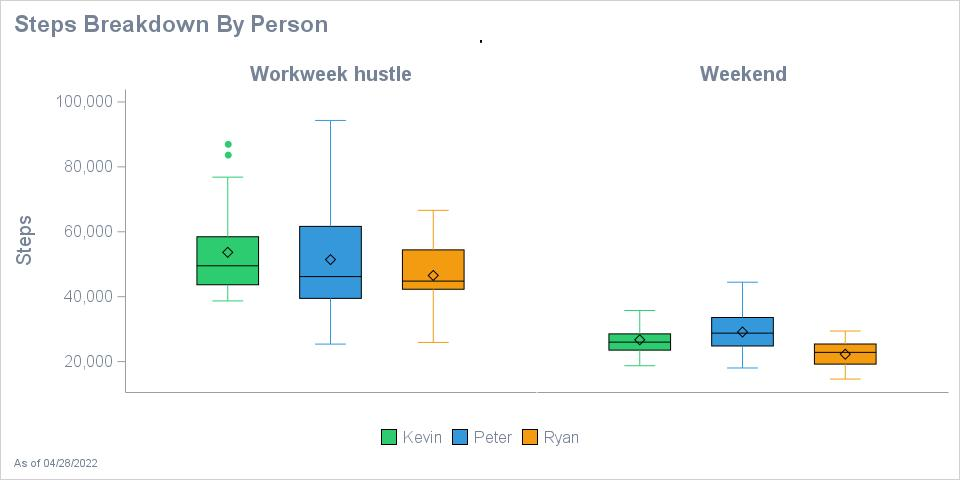

In [48]:
ods listing gpath="&outpath";
ods graphics / width=10in height=5in imagename="StepBreakdown" imagefmt=jpeg;



title &fmtTitle "Steps Breakdown By Person";
title2 "";
footnote &fmtFootnote  "As of &footnoteDate";

proc sgpanel data=fitbit_detail
             dattrmap=attrs
;
    panelby Type /
        layout=columnlattice 
        novarname
        nowall
        noborder
        headerattrs=(color=&textColor size=14pt weight=bold)
        headerbackcolor=white
        noheaderborder
        colheaderpos=top
        sort=descending
    ;
    vbox Steps / 
        group=Person
        attrID=myID
        lineattrs=(color=black)
        meanAttrs=(color=black symbol=Diamond)
        medianAttrs=(color=black)
        outlierAttrs=(symbol=circleFilled size=8pt)
        ;
    colaxis &fmtYaxis;
    rowaxis &fmtXaxis;
    keylegend / 
        position=bottom
        exclude=("Loser")
        noborder
        title=""
        scale=1.5
        valueattrs=(color=&textColor size=12pt);
run;

ods graphics / reset;